##Bee Identification

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, Dropout, Flatten, GaussianNoise, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
TRAIN_PATH = '/content/gdrive/MyDrive/small/train'
TEST_PATH  = '/content/gdrive/MyDrive/small/test'
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNEL = 3
EPOCHS = 15

In [ ]:
files = os.listdir(TRAIN_PATH)
OUTPUT_CLASSES = len(files)
print(files)

['megachile_campanulae_f', 'melissodes_comptoides_f', 'melissodes_communis_f', 'megachile_petulans_f', 'anthophora_abrupta_f', 'habropoda_laboriosa_f']


In [ ]:
Conv_Base = ResNet50( weights = 'imagenet')

for layer in Conv_Base.layers[:-8]:
    layer.trainable = False

model = Sequential()
model.add(GaussianNoise(.5))
model.add(Conv_Base)
#model.add(AveragePooling2D())
model.add(Flatten())
model.add(Dense(units = 256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = OUTPUT_CLASSES, activation = 'softmax'))

##Train the Species Label

In [ ]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    batch_size=32,
    class_mode='binary',
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH))

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    TEST_PATH,
    shuffle=False,
    class_mode='binary',
    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH))

Found 6355 images belonging to 6 classes.
Found 784 images belonging to 6 classes.


In [ ]:
optimizer = Adam()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
             EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
              ModelCheckpoint('/content/gdrive/MyDrive/small/best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=False)
             ]

In [ ]:
history = model.fit(train_generator,
                    epochs=EPOCHS,
                    validation_data=validation_generator, callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - ETA: 0s - loss: 0.8256 - accuracy: 0.8198
Epoch 1: saving model to /content/gdrive/MyDrive/small/best_model.h5
199/199 [==============================] - 1270s 6s/step - loss: 0.8256 - accuracy: 0.8198 - val_loss: 0.4807 - val_accuracy: 0.8635
Epoch 2/15
199/199 [==============================] - ETA: 0s - loss: 0.1703 - accuracy: 0.9566
Epoch 2: saving model to /content/gdrive/MyDrive/small/best_model.h5
199/199 [==============================] - 124s 622ms/step - loss: 0.1703 - accuracy: 0.9566 - val_loss: 0.3920 - val_accuracy: 0.8941
Epoch 3/15
199/199 [==============================] - ETA: 0s - loss: 0.0891 - accuracy: 0.9748
Epoch 3: saving model to /content/gdrive/MyDrive/small/best_model.h5
199/199 [==============================] - 125s 627ms/step - loss: 0.0891 - accuracy: 0.9748 - val_loss: 0.3663 - val_accuracy: 0.9158
Epoch 4/15
199/199 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9825
Epoch 

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_2 (GaussianN  (None, None, None, None)  0        
 oise)                                                           
                                                                 
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 flatten_2 (Flatten)         (None, 1000)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               256256    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 1542      
                                                      

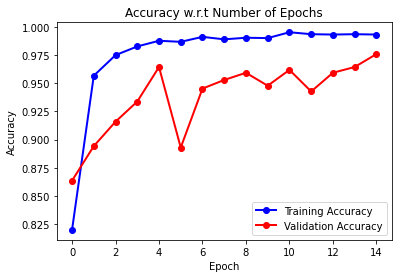

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
No_Of_Epochs = range(EPOCHS)

plt.figure()
plt.plot(No_Of_Epochs, train_acc, marker = '.', color = 'blue', markersize = 12, 
                 linewidth = 2, label = 'Training Accuracy')
plt.plot(No_Of_Epochs, val_acc, marker = '.', color = 'red', markersize = 12, 
                 linewidth = 2, label = 'Validation Accuracy')

plt.title('Accuracy w.r.t Number of Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()



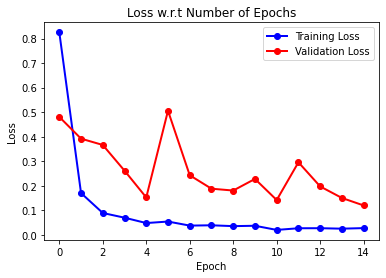

In [ ]:
plt.figure()

plt.plot(No_Of_Epochs, train_loss, marker = '.', color = 'blue', markersize = 12, 
                 linewidth = 2, label = 'Training Loss')
plt.plot(No_Of_Epochs, val_loss, marker = '.', color = 'red', markersize = 12, 
                 linewidth = 2, label = 'Validation Loss')


plt.title('Loss w.r.t Number of Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

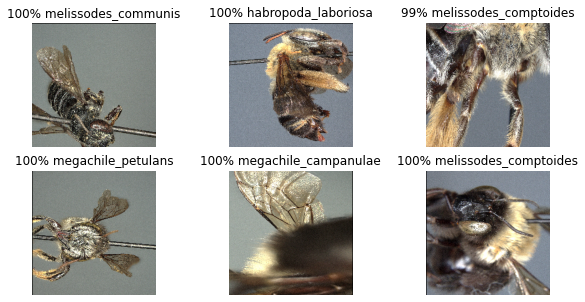

In [ ]:

validation_img_paths = []
for tgtclass in files:
  filename = TEST_PATH + '/' + tgtclass
  images = os.listdir(filename)
  index  = np.random.randint(0, len(images)-1) 
  imagepath = TEST_PATH + '/' + tgtclass + '/' + images[index] 
  validation_img_paths.append(imagepath )

img_list = [Image.open(img_path) for img_path in validation_img_paths]
validation_batch = np.stack([preprocess_input(np.array(img.resize((IMAGE_HEIGHT,IMAGE_WIDTH))))
                             for img in img_list])

pred_probs = model.predict(validation_batch)

plt.figure( figsize=(10, 5))
half = (int)(len(img_list)/2)
#fig, axs = plt.subplots(2, half, figsize=(20, 5))
j = 0
for i, img in enumerate(img_list):
    if (i > half):
      j = 1
    ax =  plt.subplot(2, half, i + 1)
    ax.axis('off')
    maxitem = np.argmax(pred_probs[i])
    ax.set_title("{:.0f}% {}".format(100*pred_probs[i,maxitem], files[maxitem][:-2]))
    ax.imshow(img)

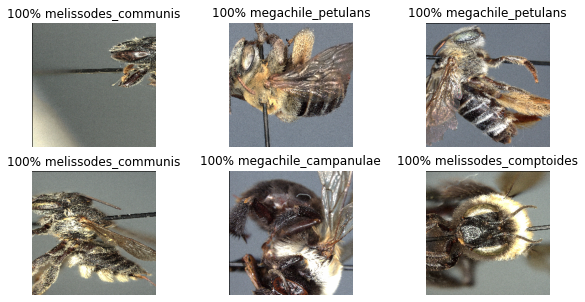

In [ ]:
plt.figure( figsize=(10, 5))
half = (int)(len(img_list)/2)
#fig, axs = plt.subplots(2, half, figsize=(20, 5))
j = 0
for i, img in enumerate(img_list):
    if (i > half):
      j = 1
    ax =  plt.subplot(2, half, i + 1)
    ax.axis('off')
    maxitem = np.argmax(pred_probs[i])
    ax.set_title("{:.0f}% {}".format(100*pred_probs[i,maxitem], files[maxitem][:-2]))
    ax.imshow(img)

In [ ]:
num_test_samples = 500
batch_size = 32
Y_pred = model.predict(validation_generator, num_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = files
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))


Confusion Matrix
[[206   4   1   0   0   0]
 [  5 206   1   0   0   0]
 [  1   0 229   1   0   0]
 [  1   0   1  18   0   0]
 [  0   1   0   0  29   0]
 [  1   1   0   0   1  77]]
Classification Report
                         precision    recall  f1-score   support

 megachile_campanulae_f       0.96      0.98      0.97       211
melissodes_comptoides_f       0.97      0.97      0.97       212
  melissodes_communis_f       0.99      0.99      0.99       231
   megachile_petulans_f       0.95      0.90      0.92        20
   anthophora_abrupta_f       0.97      0.97      0.97        30
  habropoda_laboriosa_f       1.00      0.96      0.98        80

               accuracy                           0.98       784
              macro avg       0.97      0.96      0.97       784
           weighted avg       0.98      0.98      0.98       784



## Doing The Genus 

Map the Genuses together

In [ ]:
names = train_generator.class_indices
print(train_generator.class_indices)

genuslist = []
for fi in files:
  name = fi.split('_')
  genuslist.append(name[0])

genuslist = np.unique(genuslist)
genuslist = np.ndarray.tolist(genuslist)
genuslist.sort()

keys_from_dict = list(names.values())
names_from_dict  = list(names.keys())

mapping_comb = []
for i, fi in enumerate(names_from_dict):
  nm     = fi.split('_')
  val    = genuslist.index(nm[0])
  mapping_comb.append(val)

old_to_new = mapping_comb

OUTPUT_CLASSES_G = len(genuslist)


{'anthophora_abrupta_f': 0, 'habropoda_laboriosa_f': 1, 'megachile_campanulae_f': 2, 'megachile_petulans_f': 3, 'melissodes_communis_f': 4, 'melissodes_comptoides_f': 5}


In [ ]:
print(old_to_new)

[0, 1, 2, 2, 3, 3]

In [ ]:
Conv_Baseg = ResNet50( weights = 'imagenet')

for layer in Conv_Baseg.layers[:-8]:
    layer.trainable = False

modelg = Sequential()
modelg.add(GaussianNoise(.5))
modelg.add(Conv_Baseg)
modelg.add(Flatten())
modelg.add(Dense(units = 256, activation = 'relu'))
modelg.add(Dropout(0.5))
modelg.add(Dense(units = OUTPUT_CLASSES_G, activation = 'softmax'))

In [ ]:
optimizer = Adam()
modelg.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
callbacksg = [
             EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10),
             ModelCheckpoint('/content/gdrive/MyDrive/small/best_model_g.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=False)
             ]

In [ ]:
# the wrapping generator
def new_gen(gen):
  for data, labels in gen:
    print(data) 
    print(labels)
    labels = [old_to_new[int(n)] for n in labels]
    labels = np.array(labels)
    # now you can call np_utils.to_categorical method 
    # if you would like one-hot encoded labels
    yield data, labels

In [ ]:
import math
EPOCHSG = 10
BATCH_SIZE = 32
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE))

# use the number of samples to determine the number of steps per epoch
# this is done for you when you're just doing the train_generator
TRAINING_SIZE = train_generator.samples 
VALIDATION_SIZE = validation_generator.samples

steps_per_epoch = compute_steps_per_epoch(TRAINING_SIZE)
val_steps = compute_steps_per_epoch(VALIDATION_SIZE)

historyg = modelg.fit(new_gen(train_generator),
                    epochs=EPOCHSG,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=new_gen(validation_generator), 
                    validation_steps=val_steps, callbacks=callbacksg)

Epoch 1/10
199/199 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9929
Epoch 1: saving model to /content/gdrive/MyDrive/small/best_model_g.h5
199/199 [==============================] - 134s 675ms/step - loss: 0.0317 - accuracy: 0.9929 - val_loss: 0.3354 - val_accuracy: 0.9362
Epoch 2/10
199/199 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9945
Epoch 2: saving model to /content/gdrive/MyDrive/small/best_model_g.h5
199/199 [==============================] - 125s 627ms/step - loss: 0.0244 - accuracy: 0.9945 - val_loss: 0.1320 - val_accuracy: 0.9681
Epoch 3/10
199/199 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9945
Epoch 3: saving model to /content/gdrive/MyDrive/small/best_model_g.h5
199/199 [==============================] - 125s 632ms/step - loss: 0.0237 - accuracy: 0.9945 - val_loss: 0.1522 - val_accuracy: 0.9656
Epoch 4/10
199/199 [==============================] - ETA: 0s - loss: 0.0141 - accuracy: 0.997

In [ ]:
modelg.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_4 (GaussianN  (None, None, None, None)  0        
 oise)                                                           
                                                                 
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 flatten_4 (Flatten)         (None, 1000)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               256256    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 1028      
                                                      

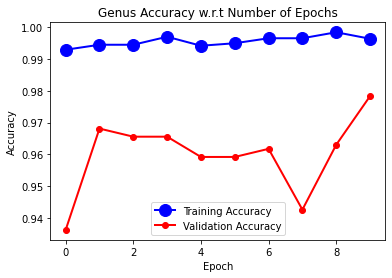

In [ ]:
train_acc_g = historyg.history['accuracy']
val_acc_g = historyg.history['val_accuracy']
train_loss_g = historyg.history['loss']
val_loss_g = historyg.history['val_loss']
No_Of_Epochs = range(EPOCHSG)

plt.figure()
plt.plot(No_Of_Epochs, train_acc_g, marker = 'o', color = 'blue', markersize = 12, 
                 linewidth = 2, label = 'Training Accuracy')
plt.plot(No_Of_Epochs, val_acc_g, marker = '.', color = 'red', markersize = 12, 
                 linewidth = 2, label = 'Validation Accuracy')

plt.title('Genus Accuracy w.r.t Number of Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()


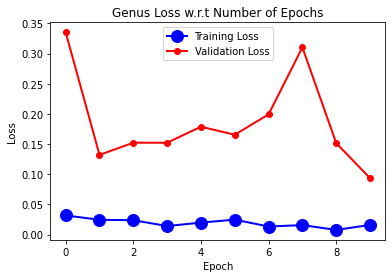

In [ ]:
plt.figure()

plt.plot(No_Of_Epochs, train_loss_g, marker = 'o', color = 'blue', markersize = 12, 
                 linewidth = 2, label = 'Training Loss')
plt.plot(No_Of_Epochs, val_loss_g, marker = '.', color = 'red', markersize = 12, 
                 linewidth = 2, label = 'Validation Loss')


plt.title('Genus Loss w.r.t Number of Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [ ]:

validation_img_paths = []
for tgtclass in files:
  filename = TEST_PATH + '/' + tgtclass
  images = os.listdir(filename)
  index  = np.random.randint(0, len(images)-1) 
  imagepath = TEST_PATH + '/' + tgtclass + '/' + images[index] 
  validation_img_paths.append(imagepath )

img_list = [Image.open(img_path) for img_path in validation_img_paths]
validation_batch = np.stack([preprocess_input(np.array(img.resize((IMAGE_HEIGHT,IMAGE_WIDTH))))
                             for img in img_list])

pred_probs = modelg.predict(validation_batch)



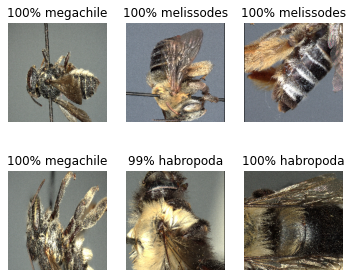

In [ ]:
plt.figure( figsize=(6, 5))
half = (int)(len(img_list)/2)
#fig, axs = plt.subplots(2, half, figsize=(20, 5))
j = 0
for i, img in enumerate(img_list):
    if (i > half):
      j = 1
    ax =  plt.subplot(2, half, i + 1)
    ax.axis('off')
    maxitem = np.argmax(pred_probs[i])
    ax.set_title("{:.0f}% {}".format(100*pred_probs[i,maxitem], genuslist[maxitem]))
    ax.imshow(img)

In [ ]:
num_test_samples = 500
batch_size = 32
Y_pred = model.predict(validation_generator, num_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
print('Confusion Matrix')
outclass = np.ndarray.tolist(validation_generator.classes)
outputs = [old_to_new[y] for y in outclass]
print(confusion_matrix(outputs, y_pred))


Confusion Matrix
[[206   4   1   0   0   0]
 [  5 206   1   0   0   0]
 [  2   0 230  19   0   0]
 [  1   2   0   0  30  77]
 [  0   0   0   0   0   0]
 [  0   0   0   0   0   0]]


In [ ]:
print('Classification Report')
print(classification_report(outputs, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       211
           1       0.97      0.97      0.97       212
           2       0.99      0.92      0.95       251
           3       0.00      0.00      0.00       110
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.82       784
   macro avg       0.49      0.48      0.48       784
weighted avg       0.84      0.82      0.83       784



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
